# Challenge: If a tree falls in the forest...

So here's what you should do. Pick a dataset. It could be one you've worked with before or it could be a new one. Then build the best decision tree you can.

Now try to match that with the simplest random forest you can. For our purposes measure simplicity with runtime. Compare that to the runtime of the decision tree. This is imperfect but just go with it.


## Another go at predicting job satisfaction of data scientists

This notebook analyzes data from a Kaggle survey data on data scientists to predict job satisfaction and two test the run time of complex and simple random forest models.

### The data

Available from [here](https://www.kaggle.com/datasets)

Kaggle conducted an industry-wide survey to establish a comprehensive view of the state of data science and machine learning. The survey received over 16,000 responses and we learned a ton about who is working with data, what’s happening at the cutting edge of machine learning across industries, and how new data scientists can best break into the field.

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn import ensemble
import time
%matplotlib inline

In [96]:
# Loading the data
# Loading data from csv gave UnicodeError, but not from Excel?
fullsurvey = pd.read_excel('multipleChoice.xlsx')
print(fullsurvey.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16716 entries, 0 to 16715
Columns: 228 entries, GenderSelect to JobFactorPublishingOpportunity
dtypes: float64(13), object(215)
memory usage: 29.1+ MB
None


In [6]:
cols = fullsurvey.columns
for col in cols:
    print(col)

GenderSelect
Country
Age
EmploymentStatus
StudentStatus
LearningDataScience
CodeWriter
CareerSwitcher
CurrentJobTitleSelect
TitleFit
CurrentEmployerType
MLToolNextYearSelect
MLMethodNextYearSelect
LanguageRecommendationSelect
PublicDatasetsSelect
LearningPlatformSelect
LearningPlatformUsefulnessArxiv
LearningPlatformUsefulnessBlogs
LearningPlatformUsefulnessCollege
LearningPlatformUsefulnessCompany
LearningPlatformUsefulnessConferences
LearningPlatformUsefulnessFriends
LearningPlatformUsefulnessKaggle
LearningPlatformUsefulnessNewsletters
LearningPlatformUsefulnessCommunities
LearningPlatformUsefulnessDocumentation
LearningPlatformUsefulnessCourses
LearningPlatformUsefulnessProjects
LearningPlatformUsefulnessPodcasts
LearningPlatformUsefulnessSO
LearningPlatformUsefulnessTextbook
LearningPlatformUsefulnessTradeBook
LearningPlatformUsefulnessTutoring
LearningPlatformUsefulnessYouTube
BlogsPodcastsNewslettersSelect
LearningDataScienceTime
JobSkillImportanceBigData
JobSkillImportanceDegre

In [174]:
# Getting rid of columns which aren't useful for our model
survey = fullsurvey.loc[:, ['Country', 'Age', 'EmploymentStatus', 'LearningCategorySelftTaught',
                            'LearningCategoryOnlineCourses', 'LearningCategoryWork', 'LearningCategoryUniversity',
                            'LearningCategoryKaggle', 'LearningCategoryOther', 'EmployerIndustry',
                            'UniversityImportance', 'TimeGatheringData', 'TimeModelBuilding',
                            'TimeProduction', 'TimeVisualizing', 'TimeFindingInsights', 'TimeOtherSelect',
                            'RemoteWork', 'CompensationAmount', 'CompensationCurrency', 'JobSatisfaction']]

# Cleaning JobSatisfaction
survey['JobSatisfaction'].replace('10 - Highly Satisfied', 10, inplace=True)
survey['JobSatisfaction'].replace('1 - Highly Dissatisfied', 1, inplace=True)
survey['JobSatisfaction'].replace('I prefer not to share', np.nan, inplace=True)

# Cleaning CompensationAmount: Change to numeric, drop if NaN
survey['CompensationAmount'] = pd.to_numeric(survey['CompensationAmount'], errors='coerce')

# Cleaning CompensationAmount: Getting rid of negative amounts, errors
# Cleaning CompensationAmount: Drop amounts considered too small (less than 10000 in any currency)
survey['CompensationAmount'] = survey['CompensationAmount'].where(survey['CompensationAmount']>10000, np.nan)

#Drop NaN in JobSatisfaction (may introduce some bias)
survey.dropna(inplace=True, subset=['JobSatisfaction'])

# Cleaning Age, ignore under 18 years (go back to school!) and over 80
survey['Age'] = survey['Age'].where(survey['Age']>18,np.nan)
survey['Age'] = survey['Age'].where(survey['Age']<80,np.nan)

print(survey.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6529 entries, 0 to 16712
Data columns (total 21 columns):
Country                          6511 non-null object
Age                              6429 non-null float64
EmploymentStatus                 6529 non-null object
LearningCategorySelftTaught      6514 non-null float64
LearningCategoryOnlineCourses    6522 non-null float64
LearningCategoryWork             6517 non-null float64
LearningCategoryUniversity       6514 non-null float64
LearningCategoryKaggle           6519 non-null float64
LearningCategoryOther            6512 non-null float64
EmployerIndustry                 6515 non-null object
UniversityImportance             6518 non-null object
TimeGatheringData                6528 non-null float64
TimeModelBuilding                6526 non-null float64
TimeProduction                   6517 non-null float64
TimeVisualizing                  6527 non-null float64
TimeFindingInsights              6521 non-null float64
TimeOtherSelect 

2085
1649


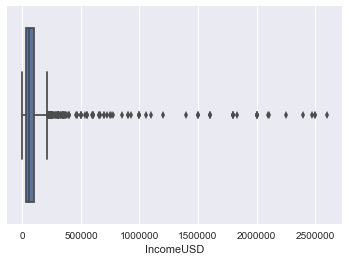

In [175]:
# Cleaning CompensationAmount

# Change to numeric, set to NaN if error occurs
survey['CompensationAmount'] = pd.to_numeric(survey['CompensationAmount'], errors='coerce')

# Cleaning CompensationAmount: Getting rid of negative amounts, errors
# Cleaning CompensationAmount: Drop amounts considered too small (less than 10000 in any currency)
survey['CompensationAmount'] = survey['CompensationAmount'].where(survey['CompensationAmount']>10000, np.nan)

# Check how many of CompensationAmount is unspecified in terms of currency
print(survey.CompensationCurrency.isnull().sum())

#Remove outlier
incomeoutlier = survey.loc[survey.CompensationCurrency.isnull(), 'CompensationAmount'].max()
survey = survey.loc[survey['CompensationAmount'] != incomeoutlier, :]

# Assume the rest of the unknown currencies are in USD [NB: This is a big assumption...]
survey.CompensationCurrency.fillna('USD', inplace=True)

# Dealing with multiple currencies in Compensation Amount 
currencies = pd.read_csv('conversionRates.csv')

#Keep only useful variables
currencies = currencies[['originCountry', 'exchangeRate']]

#Left join to match CompensationCurrency and exchangeRates
survey = pd.merge(survey, currencies, how='left',
                  left_on='CompensationCurrency',
                  right_on='originCountry')

# Convert to all compensation to USD
survey['IncomeUSD'] = survey['CompensationAmount']*survey['exchangeRate']

print(survey.IncomeUSD.isnull().sum())

# Three outliers to remove, one clearly a mistake and two of compensation >USD2.5m
incomeoutlier = survey.IncomeUSD.max()
survey = survey.loc[survey['IncomeUSD'] != incomeoutlier, :]
incomeoutlier = survey.IncomeUSD.max()
survey = survey.loc[survey['IncomeUSD'] != incomeoutlier, :]
incomeoutlier = survey.IncomeUSD.max()
survey = survey.loc[survey['IncomeUSD'] != incomeoutlier, :]

sns.boxplot(survey.IncomeUSD)
plt.show()

In [176]:
# RF model cannot handle NaN, therefore drop all
survey.dropna(inplace=True)
survey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4380 entries, 5 to 6522
Data columns (total 24 columns):
Country                          4380 non-null object
Age                              4380 non-null float64
EmploymentStatus                 4380 non-null object
LearningCategorySelftTaught      4380 non-null float64
LearningCategoryOnlineCourses    4380 non-null float64
LearningCategoryWork             4380 non-null float64
LearningCategoryUniversity       4380 non-null float64
LearningCategoryKaggle           4380 non-null float64
LearningCategoryOther            4380 non-null float64
EmployerIndustry                 4380 non-null object
UniversityImportance             4380 non-null object
TimeGatheringData                4380 non-null float64
TimeModelBuilding                4380 non-null float64
TimeProduction                   4380 non-null float64
TimeVisualizing                  4380 non-null float64
TimeFindingInsights              4380 non-null float64
TimeOtherSelect  

In [177]:
# Converting strings to float for RF model
dummies = pd.get_dummies(survey[['EmploymentStatus', 'EmployerIndustry', 'RemoteWork', 'UniversityImportance']])
dummies.head()                                                 

,EmploymentStatus_Employed full-time,EmploymentStatus_Employed part-time,"EmploymentStatus_Independent contractor, freelancer, or self-employed",EmployerIndustry_Academic,EmployerIndustry_CRM/Marketing,EmployerIndustry_Financial,EmployerIndustry_Government,EmployerIndustry_Hospitality/Entertainment/Sports,EmployerIndustry_Insurance,EmployerIndustry_Internet-based,...,RemoteWork_Most of the time,RemoteWork_Never,RemoteWork_Rarely,RemoteWork_Sometimes,UniversityImportance_Important,"UniversityImportance_N/A, I did not receive any formal education",UniversityImportance_Not at all important,UniversityImportance_Not very important,UniversityImportance_Somewhat important,UniversityImportance_Very important
5,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
6,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
8,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
9,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


# Random Forest model 1: The kitchen sink at full Jobsatisfaction

In [178]:
# Create X and y
survey_select = survey.loc[:, ['Age', 'LearningCategorySelftTaught',
                               'LearningCategoryOnlineCourses', 'LearningCategoryWork', 'LearningCategoryUniversity',
                               'LearningCategoryKaggle', 'LearningCategoryOther','TimeGatheringData',
                               'TimeModelBuilding', 'TimeProduction', 'TimeVisualizing',
                               'TimeFindingInsights', 'TimeOtherSelect', 'IncomeUSD']]


X = pd.concat([survey_select, dummies], axis=1)


y = survey['JobSatisfaction']

#Split train and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

print(type(y_train))

# Create RF instance
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)
r2_train = rf.score(X_train, y_train)
print("R2 train: ", r2_train)

#Apply to test data
r2_test = rf.score(X_test, y_test)
print("R2 test: ", r2_test)

y_hat = rf.predict(X_test)

# Confusion matrix
confused = pd.crosstab(y_test, y_hat, rownames=['Actual Satisfaction'], colnames=['Predicted Satisfaction'])
print(confused)

#Cross validation
cv = model_selection.cross_val_score(rf, X, y, cv=10, scoring = 'accuracy')
print(cv)

<class 'pandas.core.series.Series'>
R2 train:  0.989649923896
R2 test:  0.183561643836
Predicted Satisfaction  1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   \
Actual Satisfaction                                                            
1.0                        0     0     3     7     3     4     8     4     3   
2.0                        0     0     4     2     0     1     6     2     0   
3.0                        1     1     2     3     9    10    18    12     4   
4.0                        0     0     3     2     7     3    18    20     0   
5.0                        1     1     2     6    14     8    32    19     5   
6.0                        1     3     4     6    16    15    34    37     8   
7.0                        2     0     8    13    29    25    84    67    12   
8.0                        0     2    12     6    32    26    89    61    14   
9.0                        2     0     8     3     9     8    49    25    17   
10.0                       2     

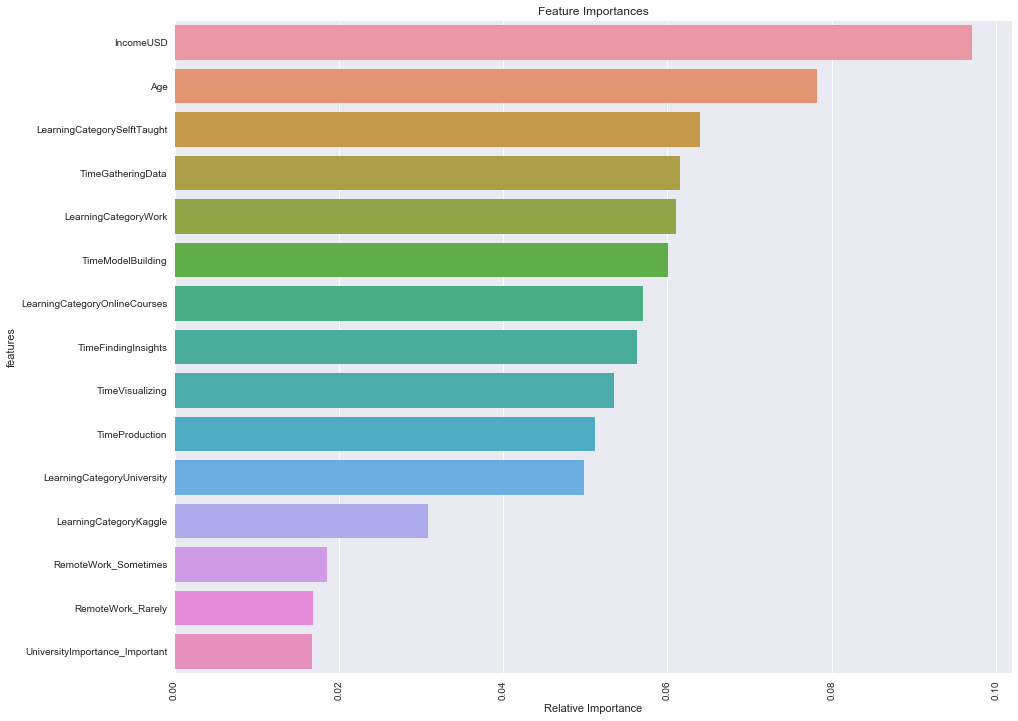

In [179]:
features = list(X.columns)
importances = rf.feature_importances_

feature_imp = pd.DataFrame({'features':features, 'importance':importances})
feature_imp.sort_values(by='importance', inplace=True, ascending=False)

plt.figure(figsize=(15,12))
plt.title('Feature Importances')
sns.barplot(y = feature_imp.features[0:15], x = feature_imp.importance[0:15], orient="h")
#plt.yticks(fontsize=16)
plt.xlabel('Relative Importance')
plt.xticks(rotation=90)
plt.show()

So that was pretty poor. Maybe n is set too low here (n_estimators=10 by default).


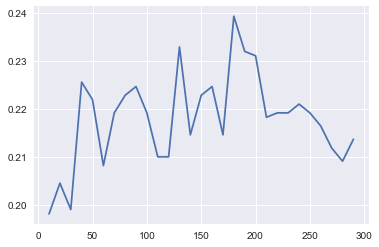

In [180]:
numberoftrees = np.arange(10,300,10)

treescore = []
for tree in numberoftrees:
    rf = ensemble.RandomForestClassifier(n_estimators=tree)
    rf.fit(X_train, y_train)
    treescore.append(rf.score(X_test, y_test))

plt.plot(numberoftrees, treescore)
plt.show()

# Random forest: Binary outcome

In [181]:
# Make Jobsatisction binary
y_bi = np.where(y>7, 1, 0)

#Split train and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_bi)

print(type(y_train))

start_time = time.clock()

# Create RF instance
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)
r2_train = rf.score(X_train, y_train)
print("R2 train: ", r2_train)
full_time = time.clock() - start_time

#Apply to test data
r2_test = rf.score(X_test, y_test)
print("R2 test: ", r2_test)

y_hat = rf.predict(X_test)

# Confusion matrix
confused = pd.crosstab(y_test, y_hat, rownames=['Actual Satisfaction'], colnames=['Predicted Satisfaction'])
print(confused)

#Cross validation
cv = model_selection.cross_val_score(rf, X, y_bi, cv=10, scoring = 'accuracy')
print(cv)

<class 'numpy.ndarray'>
R2 train:  0.983866057839
R2 test:  0.563470319635
Predicted Satisfaction    0    1
Actual Satisfaction             
0                       497  147
1                       331  120
[ 0.53075171  0.58542141  0.57403189  0.61643836  0.59817352  0.58219178
  0.56392694  0.5812357   0.56521739  0.58581236]


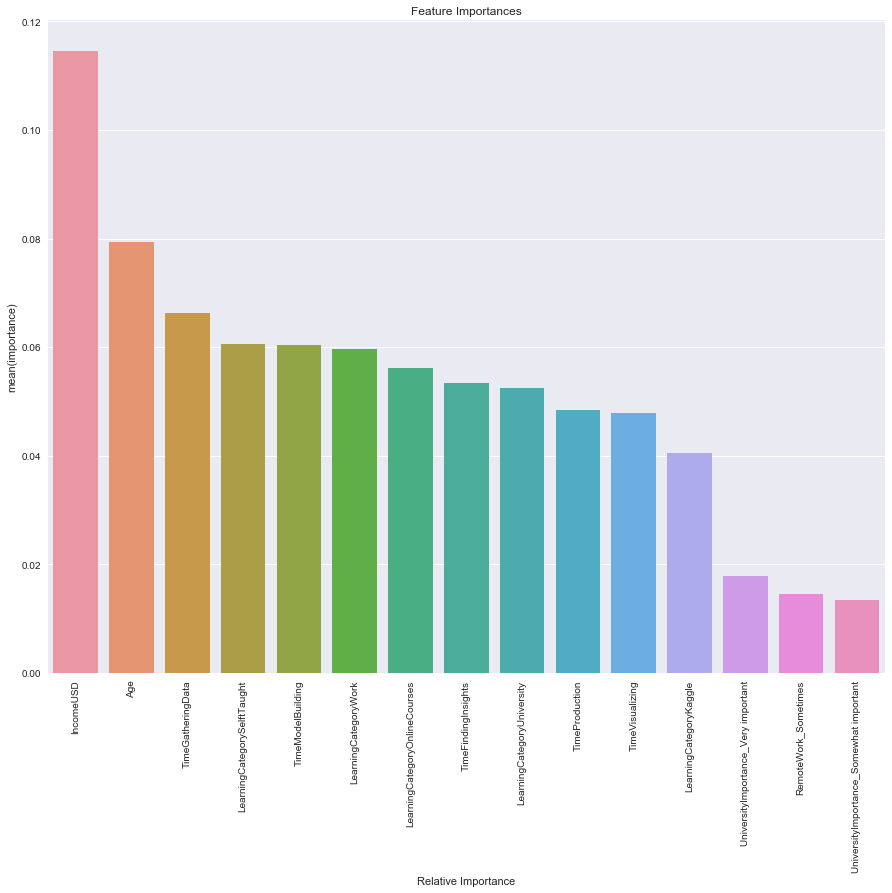

In [182]:
features = list(X.columns)
importances = rf.feature_importances_

feature_imp = pd.DataFrame({'features':features, 'importance':importances})
feature_imp.sort_values(by='importance', inplace=True, ascending=False)

plt.figure(figsize=(15,12))
plt.title('Feature Importances')
sns.barplot(x = feature_imp.features[0:15], y = feature_imp.importance[0:15])
#plt.yticks(fontsize=16)
plt.xlabel('Relative Importance')
plt.xticks(rotation=90)
plt.show()

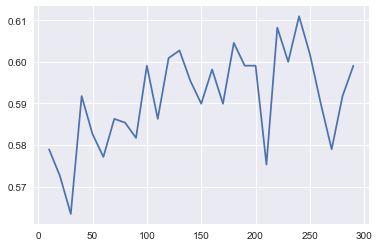

In [183]:
numberoftrees = np.arange(10,300,10)

treescore = []
for tree in numberoftrees:
    rf = ensemble.RandomForestClassifier(n_estimators=tree)
    rf.fit(X_train, y_train)
    treescore.append(rf.score(X_test, y_test))

plt.plot(numberoftrees, treescore)
plt.show()

Still can't get over that R2 > 0.6 mark...

# Simple Random forest

In [165]:
X = survey.loc[:, ['Age', 'IncomeUSD']]

#Split train and test
# Note y = y_bi
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_bi)

start_time = time.clock()
# Create RF instance
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)
r2_train = rf.score(X_train, y_train)
print("R2 train: ", r2_train)

simple_time = time.clock() - start_time

#Apply to test data
r2_test = rf.score(X_test, y_test)
print("R2 test: ", r2_test)

y_hat = rf.predict(X_test)

# Confusion matrix
confused = pd.crosstab(y_test, y_hat, rownames=['Actual Satisfaction'], colnames=['Predicted Satisfaction'])
print(confused)

#Cross validation
cv = model_selection.cross_val_score(rf, X, y_bi, cv=10, scoring = 'accuracy')
print(cv)

R2 train:  0.888888888889
R2 test:  0.561643835616
Predicted Satisfaction    0    1
Actual Satisfaction             
0                       442  227
1                       253  173
[ 0.56036446  0.50113895  0.55125285  0.56164384  0.54794521  0.56621005
  0.55251142  0.53546911  0.51029748  0.55377574]


# Time


In [129]:
print(full_time - simple_time)

-0.002002464207777166


In [184]:
#IncomeUSD is variable likely to have most noise, remove and re-test
# Create X and y
survey_select = survey.loc[:, ['Age', 'LearningCategorySelftTaught',
                               'LearningCategoryOnlineCourses', 'LearningCategoryWork', 'LearningCategoryUniversity',
                               'LearningCategoryKaggle', 'LearningCategoryOther','TimeGatheringData',
                               'TimeModelBuilding', 'TimeProduction', 'TimeVisualizing',
                               'TimeFindingInsights', 'TimeOtherSelect']]


X = pd.concat([survey_select, dummies], axis=1)

#Split train and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_bi)

# Create RF instance
rf = ensemble.RandomForestClassifier(n_estimators=250)
rf.fit(X_train, y_train)
r2_train = rf.score(X_train, y_train)
print("R2 train: ", r2_train)

#Apply to test data
r2_test = rf.score(X_test, y_test)
print("R2 test: ", r2_test)

y_hat = rf.predict(X_test)

# Confusion matrix
confused = pd.crosstab(y_test, y_hat, rownames=['Actual Satisfaction'], colnames=['Predicted Satisfaction'])
print(confused)

#Cross validation
cv = model_selection.cross_val_score(rf, X, y_bi, cv=10, scoring = 'accuracy')
print(cv)

R2 train:  1.0
R2 test:  0.581735159817
Predicted Satisfaction    0    1
Actual Satisfaction             
0                       508  140
1                       318  129
[ 0.55125285  0.60820046  0.59453303  0.58447489  0.5913242   0.58219178
  0.53652968  0.62929062  0.55377574  0.60640732]


In [168]:
rf.decision_path(X_train)

(<3285x18560 sparse matrix of type '<class 'numpy.int64'>'
 	with 563615 stored elements in Compressed Sparse Row format>,
 array([    0,  1833,  3662,  5529,  7434,  9279, 11116, 12931, 14744,
        16697, 18560], dtype=int32))

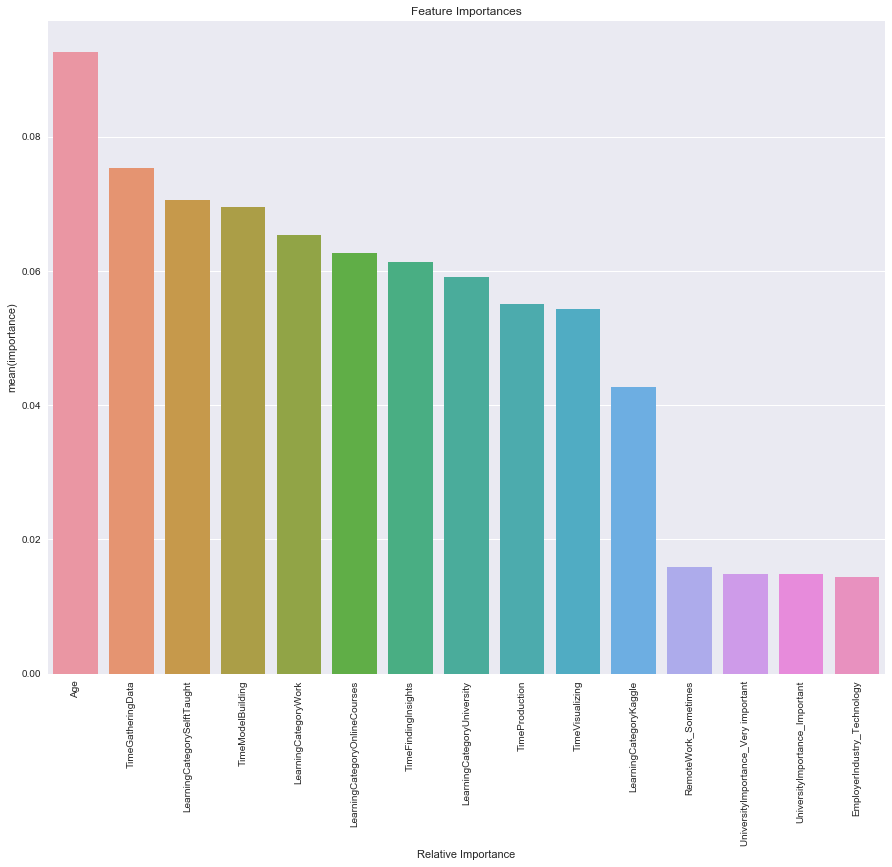

In [169]:
features = list(X.columns)
importances = rf.feature_importances_

feature_imp = pd.DataFrame({'features':features, 'importance':importances})
feature_imp.sort_values(by='importance', inplace=True, ascending=False)

plt.figure(figsize=(15,12))
plt.title('Feature Importances')
sns.barplot(x = feature_imp.features[0:15], y = feature_imp.importance[0:15])
#plt.yticks(fontsize=16)
plt.xlabel('Relative Importance')
plt.xticks(rotation=90)
plt.show()